In [40]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [41]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/SKS/Desktop/AAIC/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [42]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [43]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [44]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [45]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [46]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [47]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [48]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [49]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [50]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [51]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [52]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [53]:
final['Time']=pd.to_datetime(final['Time'])
final=final.sort_values(by='Time',ascending=True)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [54]:
final=final.iloc[:100000,:]

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [55]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I 

In [56]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [57]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited 

In [58]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [59]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [60]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [61]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [62]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [63]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:51<00:00, 1924.30it/s]


In [64]:
preprocessed_reviews[1500]
score=final.Score.values
from sklearn.model_selection import train_test_split
X_train_text,X_test_text,y_train,y_test=train_test_split(preprocessed_reviews,score,test_size=0.30,shuffle=False)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [65]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [66]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_X_train_text=count_vect.fit_transform(X_train_text)
bow_X_test_text=count_vect.transform(X_test_text)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaaah', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 49443)
the number of unique words  49443


## [4.3] TF-IDF

In [67]:
tf_idf_vect = TfidfVectorizer( min_df=10)
tfidf_X_train_text=tf_idf_vect.fit_transform(X_train_text)
tfidf_X_test_text=tf_idf_vect.transform(X_test_text)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abandon', 'abandoned', 'abc', 'abdominal', 'ability', 'able', 'abroad', 'absence', 'absent', 'absolute']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 10445)
the number of unique words including both unigrams and bigrams  10445


## [4.4] Word2Vec

In [68]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_train_sentance=[]
for sentance in X_train_text:
    list_of_train_sentance.append(sentance.split())
    
i=0
list_of_test_sentance=[]
for sentance in X_test_text:
    list_of_test_sentance.append(sentance.split())

In [69]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_train_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8550334572792053), ('fantastic', 0.8448238372802734), ('awesome', 0.8139764070510864), ('good', 0.8116801381111145), ('wonderful', 0.8023081421852112), ('excellent', 0.799105167388916), ('perfect', 0.7392058372497559), ('amazing', 0.6985270977020264), ('fabulous', 0.6914112567901611), ('incredible', 0.6888332962989807)]
[('greatest', 0.7997907400131226), ('best', 0.7382997274398804), ('tastiest', 0.6938368678092957), ('nastiest', 0.649989128112793), ('awful', 0.6086124181747437), ('terrible', 0.5883907079696655), ('experienced', 0.5834624767303467), ('closest', 0.5802252292633057), ('smoothest', 0.5757185220718384), ('nicest', 0.5623553991317749)]


In [70]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15988
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
import pickle
# average Word2Vec
# compute average word2vec for each review.
if os.path.isfile('sent_vectors_train.pkl') and os.path.isfile('sent_vectors_test.pkl'):
    with open('sent_vectors_train.pkl', 'rb') as f:
        sent_vectors_train = pickle.load(f)
    with open('sent_vectors_test.pkl', 'rb') as f:
        sent_vectors_test = pickle.load(f)
else:
    sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_train_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors_train.append(sent_vec)
    print(len(sent_vectors_train))
    print(len(sent_vectors_train[0]))

    sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors_test.append(sent_vec)
    print(len(sent_vectors_test))
    print(len(sent_vectors_test[0]))
    with open('sent_vectors_train.pkl', 'wb') as f:
        pickle.dump(sent_vectors_train, f)
    with open('sent_vectors_test.pkl', 'wb') as f:
        pickle.dump(sent_vectors_test, f)

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier



tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500],'n_estimators':[5,10,25,50,70]}]
model = GridSearchCV(XGBClassifier(), tuned_parameters, scoring = 'roc_auc')
model.fit(np.array(tfidf_sent_vectors_train), y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(np.array(tfidf_sent_vectors_test), y_test))


#### [4.4.1.2] TFIDF weighted W2v

In [72]:
import pickle
# average Word2Vec
# compute average word2vec for each review.
if os.path.isfile('tfidf_sent_vectors_train.pkl') and os.path.isfile('tfidf_sent_vectors_test.pkl'):
    with open('tfidf_sent_vectors_train.pkl', 'rb') as f:
        tfidf_sent_vectors_train = pickle.load(f)
    with open('tfidf_sent_vectors_test.pkl', 'rb') as f:
        tfidf_sent_vectors_test = pickle.load(f)
else:

    # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(preprocessed_reviews)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_train_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0;tfidf_sent_vectors_train # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors_train.append(sent_vec)
        row += 1

    tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors_test.append(sent_vec)
        row += 1
    with open('tfidf_sent_vectors_train.pkl', 'wb') as f:
        pickle.dump(tfidf_sent_vectors_train, f)
    with open('tfidf_sent_vectors_test.pkl', 'wb') as f:
        pickle.dump(tfidf_sent_vectors_test, f)
    


## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [39]:
# Please write all the code with proper documentation

# Checkin ROC_AUC with changing Max_Depth and Constant Min_Sample_Split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}]
model = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring = 'roc_auc')
model.fit(bow_X_train_text, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(bow_X_test_text, y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Training_ROC_AUC_Score- 0.813803045549
Testing_ROC_AUC_Score- 0.827534924793


#### Optimal max_depth is 50 

#### Testing ROC Score is 82.75%

#### Training and Testing ROC Scores are nearly same so, model is doing good job`

In [40]:
df=pd.DataFrame(model.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.429514,0.054060,0.042551,0.004184,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.623745,0.620518,0.620236,0.621500,0.001592,25,0.620376,0.621990,0.622131,0.621499,0.000796
1,1.420503,0.086993,0.046210,0.003673,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.623745,0.620518,0.620236,0.621500,0.001592,25,0.620376,0.621990,0.622131,0.621499,0.000796
2,1.405287,0.031833,0.035532,0.000446,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.623745,0.620518,0.620236,0.621500,0.001592,25,0.620376,0.621990,0.622131,0.621499,0.000796
3,1.438488,0.032207,0.044887,0.002944,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.623745,0.620518,0.620236,0.621500,0.001592,25,0.620376,0.621990,0.622131,0.621499,0.000796
4,1.946463,0.102599,0.040891,0.002821,5,5,"{'max_depth': 5, 'min_samples_split': 5}",0.703200,0.694985,0.689116,0.695767,0.005777,16,0.703265,0.706245,0.708200,0.705903,0.002029


In [41]:
df_train = df.pivot("param_max_depth", "param_min_samples_split", "mean_train_score")
df_test=df.pivot("param_max_depth", "param_min_samples_split", "mean_test_score")

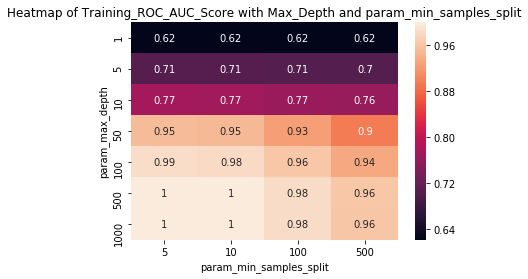

In [42]:
import seaborn as sns
ax = sns.heatmap(df_train, annot=True)
plt.title('Heatmap of Training_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

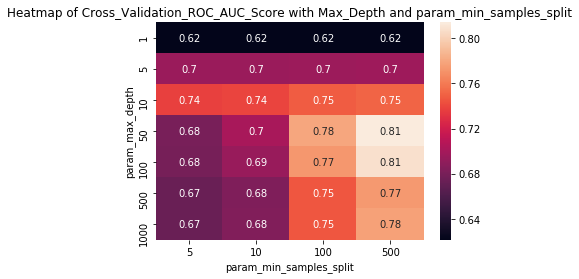

In [43]:
import seaborn as sns
ax = sns.heatmap(df_test, annot=True)
plt.title('Heatmap of Cross_Validation_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

#### When Max_Depth is 500,1000 and min_sample_split is 5,10 we can see training ROC_AUC_Score is 100% but cross_validation ROC_AUC_Score is approx. 67 which show Overfitting, our training score is high but cross_validation score is low

#### So we have to choose max_depth and min_sample split such that our training and cross_validation score is nearly same so we choose max_depth=50 and min_sample_Split=500


### ROC Curve

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


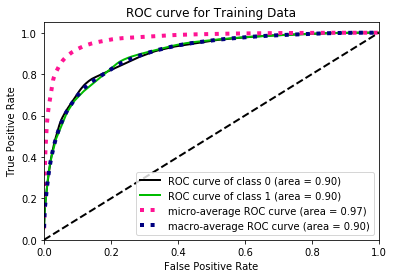

In [44]:
import scikitplot as skplt
classifier=model.best_estimator_
classifier.fit(bow_X_train_text,y_train)
y_prob_train=classifier.predict_proba(bow_X_train_text)
skplt.metrics.plot_roc_curve(y_train, y_prob_train)
plt.title('ROC curve for Training Data')
plt.show()

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


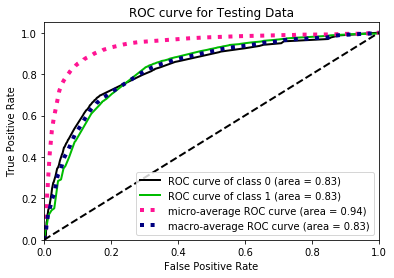

In [45]:
y_prob_test=classifier.predict_proba(bow_X_test_text)
skplt.metrics.plot_roc_curve(y_test, y_prob_test)
plt.title('ROC curve for Testing Data')
plt.show()

#### AUC for both Training and Testing is nearly same so our model is doing fine

### Accuracy Metrics 

In [46]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
pred_train=classifier.predict(bow_X_train_text)
pred_test=classifier.predict(bow_X_test_text)
accuracy_bow_train=accuracy_score(y_train,pred_train)*100
accuracy_bow_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_bow_train))
print("Testing Accuracy- {}%".format(accuracy_bow_test))
print("Training Error- {}%".format(100-accuracy_bow_train))
print("Testing Error- {}%".format(100-accuracy_bow_test))

Training Accuracy- 91.11571428571429%
Testing Accuracy- 87.57666666666667%
Training Error- 8.88428571428571%
Testing Error- 12.423333333333332%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 87.57%

### Classification Report 

In [47]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.58      0.35      0.43      4103
          1       0.90      0.96      0.93     25897

avg / total       0.86      0.88      0.86     30000



#### For Negative Reviews Recall is 0.35 or 35% which means out of all Actual Negative Points we are just predicting 35% of negative correctly which is bad while in Positive Reviews we are predicting 96% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low as compared to Positive Review(1)

### Confusion Matrix

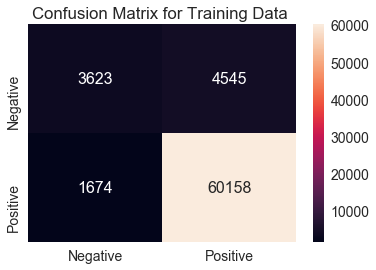

In [48]:
from sklearn.metrics import confusion_matrix,roc_curve
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

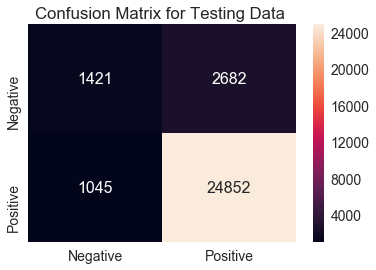

In [49]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()


#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 2682 negative reviews are predicted as positive

In [50]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR- {}".format(TPR))
print("FPR- {}".format(FPR))
print("TNR- {}".format(TNR))
print("FNR- {}".format(FNR))

TPR- 0.9025931575506646
FPR- 0.4237631792376318
TNR- 0.5762368207623683
FNR- 0.09740684244933537


In [93]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Max_Depth", "Min_Sample_Split", "Training_ROC-AUC_Score","Testing_ROC-AUC_Score"]
x.add_row(["BOW_Model","50","500","81.38","82.75"])

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [52]:
# Please write all the code with proper documentation
bow_features_text =count_vect.get_feature_names()
bow_features=bow_features_text
weights= classifier.feature_importances_
feature_weights = pd.DataFrame(weights.reshape(1,49443), columns = bow_features)
feature_weights=feature_weights.T
feature_weights.head()
feature_weights[0].sort_values(ascending = False)[0:20]

not               0.082609
great             0.049772
worst             0.039924
money             0.039676
disappointed      0.038045
best              0.034498
terrible          0.033038
awful             0.027017
delicious         0.023382
threw             0.019718
love              0.019348
horrible          0.017840
good              0.015148
return            0.013848
disappointment    0.013689
perfect           0.012610
waste             0.011559
loves             0.010971
wonderful         0.010656
favorite          0.010214
Name: 0, dtype: float64

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [53]:
# Please write all the code with proper documentation

classifier= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
classifier.fit(bow_X_train_text,y_train)
from sklearn import tree
import pydotplus
import collections
dot_data = tree.export_graphviz(classifier,
                                feature_names=bow_features,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('Bow_Word_Tree_2.png')

True

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [54]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}]
model = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_X_train_text, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(tfidf_X_test_text, y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Training_ROC_AUC_Score- 0.80136013157
Testing_ROC_AUC_Score- 0.822536265478


In [94]:
x.add_row(["TFIDF_Model","50","500","80.13","82.25"])

#### Optimal max_depth is 50 

#### Testing ROC Score is 82.25%

#### Training and Testing ROC Scores are nearly same so, model is doing good job`

In [56]:
df=pd.DataFrame(model.cv_results_)
df_train = df.pivot("param_max_depth", "param_min_samples_split", "mean_train_score")
df_test=df.pivot("param_max_depth", "param_min_samples_split", "mean_test_score")

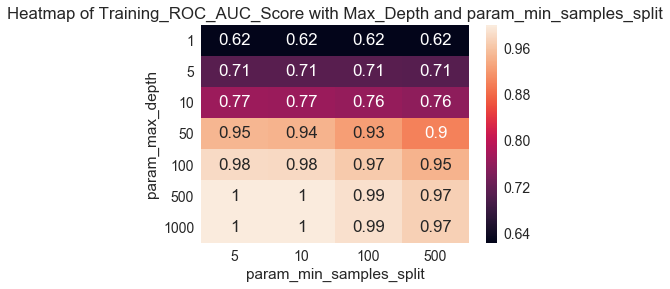

In [57]:
import seaborn as sns
ax = sns.heatmap(df_train, annot=True)
plt.title('Heatmap of Training_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

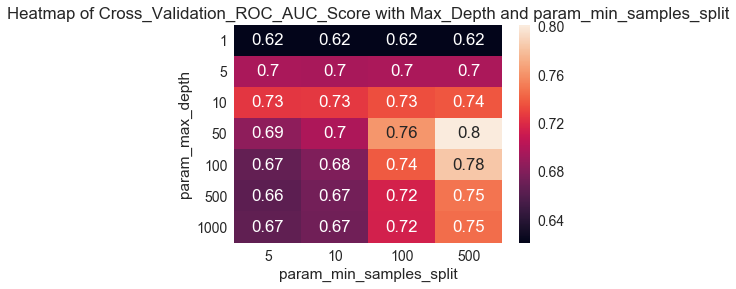

In [58]:
import seaborn as sns
ax = sns.heatmap(df_test, annot=True)
plt.title('Heatmap of Cross_Validation_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

#### When Max_Depth is 500,1000 and min_sample_split is 5,10 we can see training ROC_AUC_Score is 100% but cross_validation ROC_AUC_Score is approx. 67 which show Overfitting, our training score is high but cross_validation score is low

#### So we have to choose max_depth and min_sample split such that our training and cross_validation score is nearly same so we choose max_depth=50 and min_sample_Split=500


### ROC Curve

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


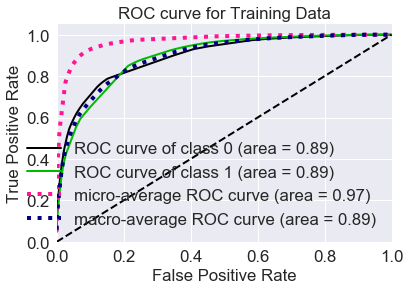

In [59]:
import scikitplot as skplt
classifier=model.best_estimator_
classifier.fit(tfidf_X_train_text, y_train)
y_prob_train=classifier.predict_proba(tfidf_X_train_text)
skplt.metrics.plot_roc_curve(y_train, y_prob_train)
plt.title('ROC curve for Training Data')
plt.show()

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


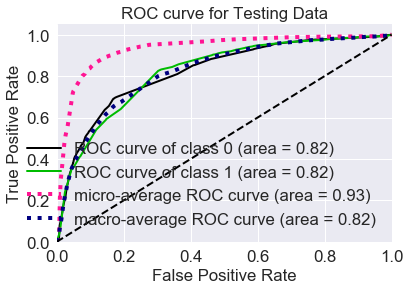

In [60]:
y_prob_test=classifier.predict_proba(tfidf_X_test_text)
skplt.metrics.plot_roc_curve(y_test, y_prob_test)
plt.title('ROC curve for Testing Data')
plt.show()

#### AUC for both Training and Testing is nearly same so our model is doing fine

## Accuracy Metrics

In [61]:
pred_train=classifier.predict(tfidf_X_train_text)
pred_test=classifier.predict(tfidf_X_test_text)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 91.57142857142857%
Testing Accuracy- 87.37666666666667%
Training Error- 8.42857142857143%
Testing Error- 12.623333333333335%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 87.37%

### Classification Report 

In [62]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.56      0.34      0.43      4103
          1       0.90      0.96      0.93     25897

avg / total       0.86      0.87      0.86     30000



#### For Negative Reviews Recall is 0.34 or 34% which means out of all Actual Negative Points we are just predicting 34% of negative correctly which is bad while in Positive Reviews we are predicting 96% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low as compared to Positive Review(1)

### Confusion Matrix

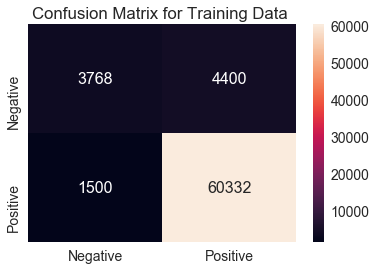

In [63]:
from sklearn.metrics import confusion_matrix,roc_curve
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

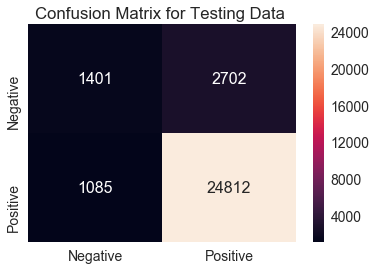

In [64]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 2702 negative reviews are predicted as positive

In [65]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR- {}".format(TPR))
print("FPR- {}".format(FPR))
print("TNR- {}".format(TNR))
print("FNR- {}".format(FNR))

TPR- 0.9017954495893
FPR- 0.4364440868865648
TNR- 0.5635559131134352
FNR- 0.0982045504107


### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [66]:
# Please write all the code with proper documentation
tfidf_features_text =tf_idf_vect.get_feature_names()
tfidf_features=tfidf_features_text
weights= classifier.feature_importances_
feature_weights = pd.DataFrame(weights.reshape(1,10445), columns = tfidf_features)
feature_weights=feature_weights.T
feature_weights.head()
feature_weights[0].sort_values(ascending = False)[0:20]


not               0.095671
great             0.048259
money             0.038626
worst             0.038092
disappointed      0.036552
best              0.032431
terrible          0.029443
awful             0.025164
horrible          0.023984
delicious         0.020143
disappointment    0.018830
love              0.017365
threw             0.015174
disappointing     0.014944
refund            0.013918
good              0.013215
return            0.012656
unfortunately     0.010602
waste             0.009952
bad               0.009710
Name: 0, dtype: float64

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [67]:
# Please write all the code with proper documentation
classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
classifier.fit(tfidf_X_train_text,y_train)
from sklearn import tree
import pydotplus
import collections
dot_data = tree.export_graphviz(classifier,feature_names=tfidf_features,out_file=None,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('TFIDF_Tree_2.png')

True

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [68]:
# Please write all the code with proper documentation
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}]
model = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring = 'roc_auc')
model.fit(sent_vectors_train, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(sent_vectors_test, y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Training_ROC_AUC_Score- 0.804587055235
Testing_ROC_AUC_Score- 0.815930219484


In [95]:
x.add_row(["Avg_Word2Vec_Model","10","500","80.45","81.59"])

#### Optimal max_depth is 10

#### Testing ROC Score is 81.59%

#### Training and Testing ROC Scores are nearly same so, model is doing good job`

In [70]:
df=pd.DataFrame(model.cv_results_)
df_train = df.pivot("param_max_depth","param_min_samples_split", "mean_train_score")
df_test=df.pivot("param_max_depth","param_min_samples_split", "mean_test_score")

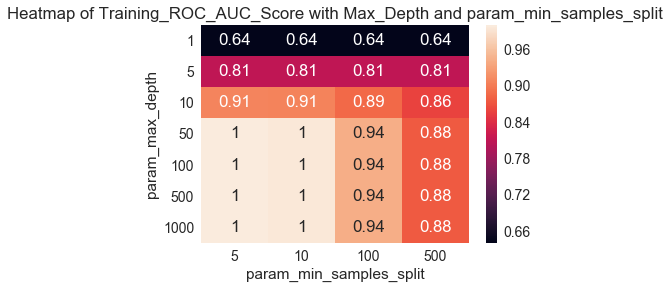

In [71]:
import seaborn as sns
ax = sns.heatmap(df_train, annot=True)
plt.title('Heatmap of Training_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

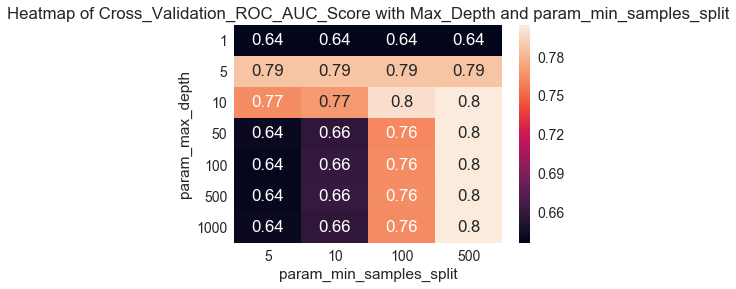

In [72]:
import seaborn as sns
ax = sns.heatmap(df_test, annot=True)
plt.title('Heatmap of Cross_Validation_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

#### When Max_Depth is 50,100,500,1000 and min_sample_split is 5,10 we can see training ROC_AUC_Score is 100% but cross_validation ROC_AUC_Score is approx. 67 which show Overfitting, our training score is high but cross_validation score is low

#### So we have to choose max_depth and min_sample split such that our training and cross_validation score is nearly same so we choose max_depth=10 and min_sample_Split=500


### ROC_Curve

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


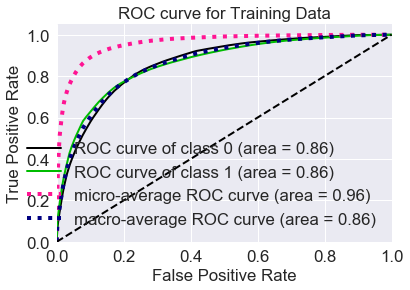

In [73]:
import scikitplot as skplt
classifier=model.best_estimator_
classifier.fit(sent_vectors_train,y_train)
y_prob_train=classifier.predict_proba(sent_vectors_train)
skplt.metrics.plot_roc_curve(y_train, y_prob_train)
plt.title('ROC curve for Training Data')
plt.show()

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


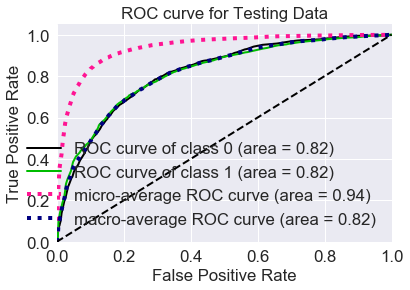

In [74]:
y_prob_test=classifier.predict_proba(sent_vectors_test)
skplt.metrics.plot_roc_curve(y_test, y_prob_test)
plt.title('ROC curve for Testing Data')
plt.show()

#### AUC for both Training and Testing is nearly same so our model is doing fine

## Accuracy Metrics

In [75]:
classifier=model.best_estimator_
classifier.fit(sent_vectors_train,y_train)
pred_train=classifier.predict(sent_vectors_train)
pred_test=classifier.predict(sent_vectors_test)
accuracy_avg_word2vec_train=accuracy_score(y_train,pred_train)*100
accuracy_avg_word2vec_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_avg_word2vec_train))
print("Testing Accuracy- {}%".format(accuracy_avg_word2vec_test))
print("Training Error- {}%".format(100-accuracy_avg_word2vec_train))
print("Testing Error- {}%".format(100-accuracy_avg_word2vec_test))


Training Accuracy- 89.51571428571428%
Testing Accuracy- 86.93333333333332%
Training Error- 10.484285714285718%
Testing Error- 13.066666666666677%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 86.93%

### Classification Report 

In [76]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.56      0.21      0.31      4103
          1       0.89      0.97      0.93     25897

avg / total       0.84      0.87      0.84     30000



#### For Negative Reviews Recall is 0.21 or 21% which means out of all Actual Negative Points we are just predicting 21% of negative correctly which is bad while in Positive Reviews we are predicting 97% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low as compared to Positive Review(1)

### Confusion Matrix

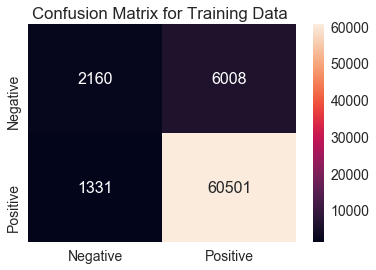

In [77]:
from sklearn.metrics import confusion_matrix,roc_curve
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

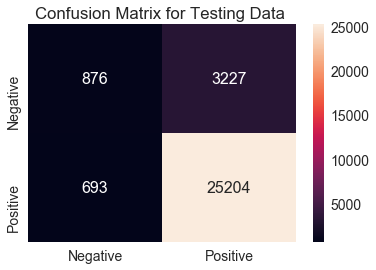

In [78]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 3227 negative reviews are predicted as positive

In [79]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR- {}".format(TPR))
print("FPR- {}".format(FPR))
print("TNR- {}".format(TNR))
print("FNR- {}".format(FNR))

TPR- 0.8864971334107137
FPR- 0.4416826003824092
TNR- 0.5583173996175909
FNR- 0.11350286658928634


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [80]:
# Please write all the code with proper documentation
tuned_parameters = [{'max_depth': [1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}]
model = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_sent_vectors_train, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(tfidf_sent_vectors_test, y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=500,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Training_ROC_AUC_Score- 0.770741829751
Testing_ROC_AUC_Score- 0.778872170354


In [96]:
x.add_row(["TFIDF_Word2Vec_Model","500","500","77.07","77.88"])

#### Optimal max_depth is 500

#### Testing ROC Score is 77.88%

#### Training and Testing ROC Scores are nearly same so, model is doing good job`

In [82]:
df=pd.DataFrame(model.cv_results_)
df_train = df.pivot("param_max_depth", "param_min_samples_split", "mean_train_score")
df_test=df.pivot("param_max_depth", "param_min_samples_split", "mean_test_score")

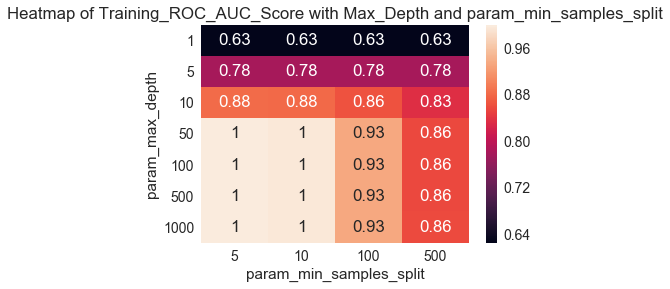

In [83]:
import seaborn as sns
ax = sns.heatmap(df_train, annot=True)
plt.title('Heatmap of Training_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

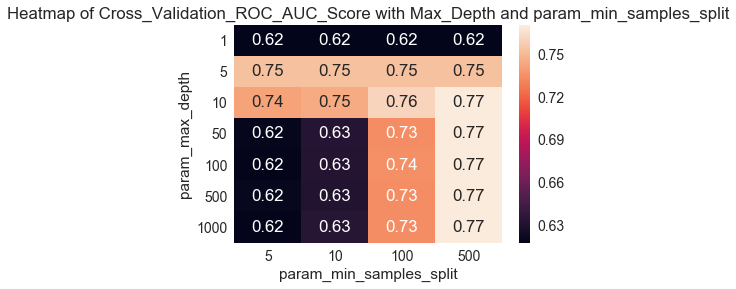

In [84]:
import seaborn as sns
ax = sns.heatmap(df_test, annot=True)
plt.title('Heatmap of Cross_Validation_ROC_AUC_Score with Max_Depth and param_min_samples_split')
plt.show()

#### When Max_Depth is 50,100,500,1000 and min_sample_split is 5,10 we can see training ROC_AUC_Score is 100% but cross_validation ROC_AUC_Score is approx. 67 which show Overfitting, our training score is high but cross_validation score is low

#### So we have to choose max_depth and min_sample split such that our training and cross_validation score is nearly same so we choose max_depth=10 and min_sample_Split=500


### ROC_Curve

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


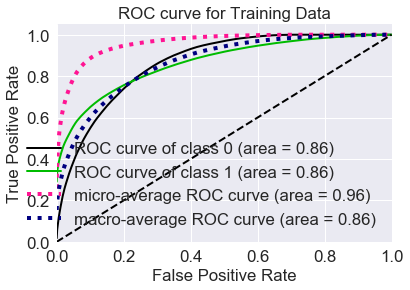

In [85]:
import scikitplot as skplt
classifier=model.best_estimator_
classifier.fit(tfidf_sent_vectors_train,y_train)
y_prob_train=classifier.predict_proba(tfidf_sent_vectors_train)
skplt.metrics.plot_roc_curve(y_train, y_prob_train)
plt.title('ROC curve for Training Data')
plt.show()

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


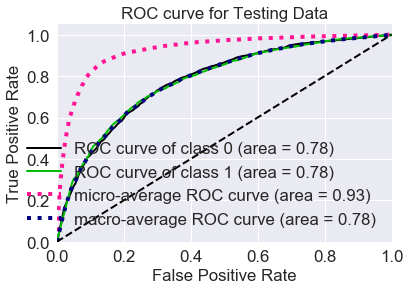

In [86]:
y_prob_test=classifier.predict_proba(tfidf_sent_vectors_test)
skplt.metrics.plot_roc_curve(y_test, y_prob_test)
plt.title('ROC curve for Testing Data')
plt.show()

## Accuracy Metrics

In [87]:
classifier=model.best_estimator_
classifier.fit(tfidf_sent_vectors_train,y_train)
pred_train=classifier.predict(tfidf_sent_vectors_train)
pred_test=classifier.predict(tfidf_sent_vectors_test)
accuracy_word2vec_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_word2vec_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_word2vec_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_word2vec_tfidf_test))
print("Training Error- {}%".format(100-accuracy_word2vec_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_word2vec_tfidf_test))


Training Accuracy- 89.33285714285715%
Testing Accuracy- 86.44333333333334%
Training Error- 10.66714285714285%
Testing Error- 13.556666666666658%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 86.44%

## Classification Report

In [88]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.51      0.18      0.26      4103
          1       0.88      0.97      0.93     25897

avg / total       0.83      0.86      0.83     30000



#### For Negative Reviews Recall is 0.18 or 18% which means out of all Actual Negative Points we are just predicting 18% of negative correctly which is bad while in Positive Reviews we are predicting 97% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low

### Confusion Matrix

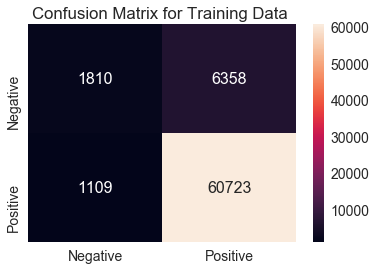

In [89]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

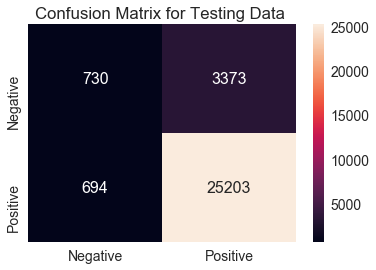

In [90]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 3373 negative reviews are predicted as positive

In [91]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.8819638857782754
FPR-0.48735955056179775
TNR-0.5126404494382022
FNR-0.11803611422172453


# [6] Conclusions

In [97]:
# Please compare all your models using Prettytable library
print(x)

+----------------------+-----------+------------------+------------------------+-----------------------+
|        Model         | Max_Depth | Min_Sample_Split | Training_ROC-AUC_Score | Testing_ROC-AUC_Score |
+----------------------+-----------+------------------+------------------------+-----------------------+
|      BOW_Model       |     50    |       500        |         81.38          |         82.75         |
|     TFIDF_Model      |     50    |       500        |         80.13          |         82.25         |
|  Avg_Word2Vec_Model  |     10    |       500        |         80.45          |         81.59         |
| TFIDF_Word2Vec_Model |    500    |       500        |         77.07          |         77.88         |
+----------------------+-----------+------------------+------------------------+-----------------------+


* BOW model is doing the best job with Decision Tree Classifier 
* BOW model have highest train and test ROC_AUC Score
* BOW model also have highest recall for Negative Reviews which shows it is distinguishing good between negative and positive reveiw compared to other models
